In [1]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: matplotlib in c:\users\ishan\appdata\roaming\python\python312\site-packages (3.10.1)




[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install osmnx


  Using cached osmnx-2.0.6-py3-none-any.whl.metadata (4.9 kB)
  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached pyogrio-0.11.1-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
Using cached osmnx-2.0.6-py3-none-any.whl (101 kB)
Using cached geopandas-1.1.1-py3-none-any.whl (338 kB)
Using cached pyogrio-0.11.1-cp312-cp312-win_amd64.whl (19.2 MB)

   ---------------------------------------- 0/3 [pyogrio]
   ---------------------------------------- 0/3 [pyogrio]
   ---------------------------------------- 0/3 [pyogrio]
   ---------------------------------------- 0/3 [pyogrio]
   ---------------------------------------- 0/3 [pyogrio]
   ---------------------------------------- 0/3 [pyogrio]
   ---------------------------------------- 0/3 [pyogrio]
   ---------------------------------------- 0/3 [pyogrio]
   ---------------------------------------- 0/3 [pyogrio]
   ------------- -------------------------- 1/3 [geopandas]
   ------------- -------------------------- 


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import osmnx as ox
import matplotlib.pyplot as plt

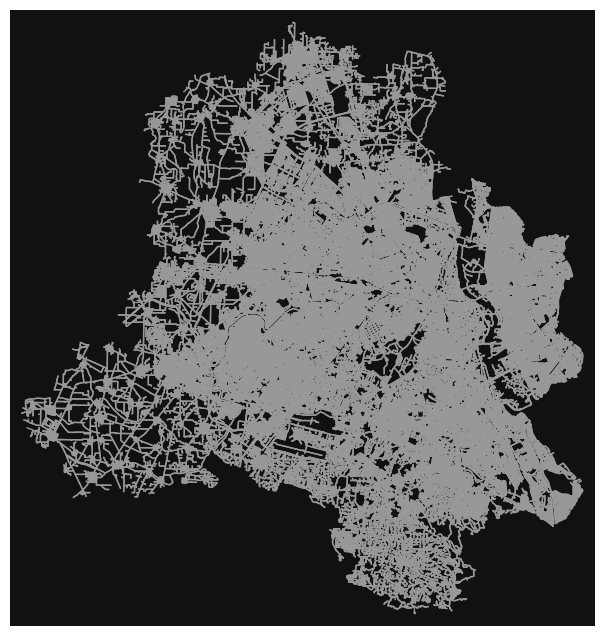

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:

ox.plot_graph(ox.graph_from_place('Delhi, India'), node_size=0)

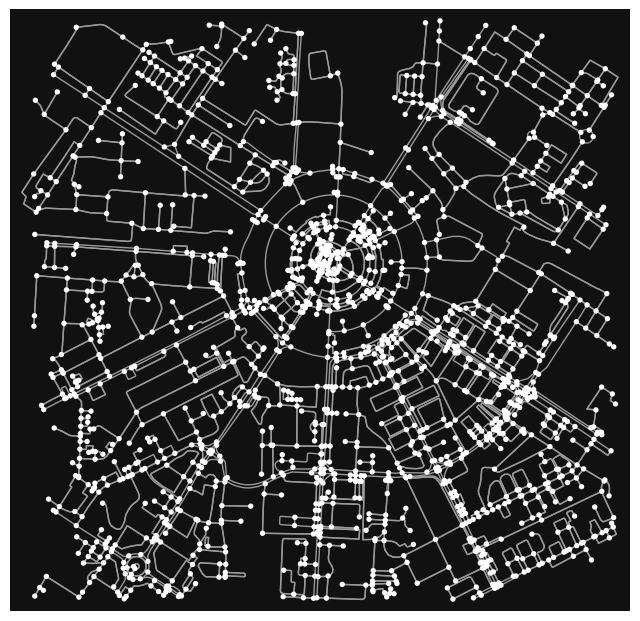

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
G = ox.graph_from_point((28.6314022, 77.2193791), dist=1000, network_type='all')
ox.plot_graph(G)

In [ ]:
G_ = ox.features_from_point((28.6314022, 77.2193791), tags = {'building': True, 'public_transport': 'platform'}, dist=50000)
# print(G.shape)
# print(G['public_transport'].value_counts())
# G['public_transport'].isna().sum()

# G[(G['public_transport'] == 'station') & (G['operator'] == 'Delhi Metro Rail Corporation Limited')]


In [ ]:
g = G_[G_['network'] == 'Delhi Metro']
metro = g[['name', 'network']].dropna().drop_duplicates().sort_values('name')


In [ ]:
# Example ID list (replace with your actual IDs)
id = [idx for idx, row in metro.iterrows()]
nid_l=[]
for way, nid in id:
   nid_l.append(nid)



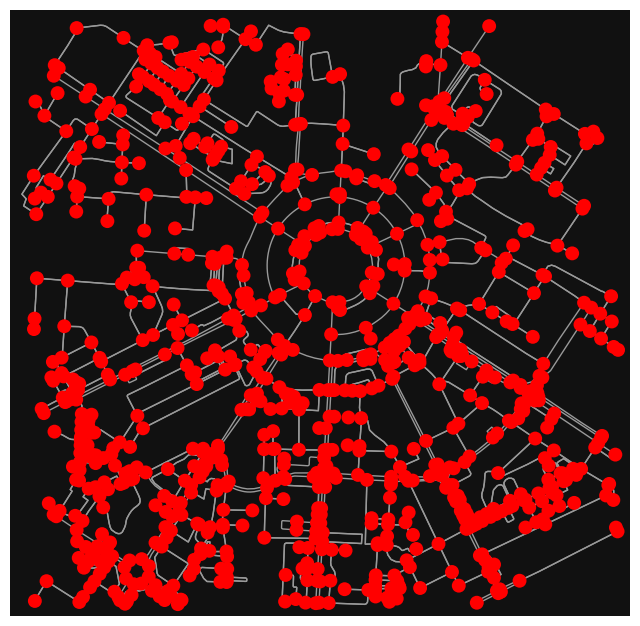

ValueError: Graph contains no edges.

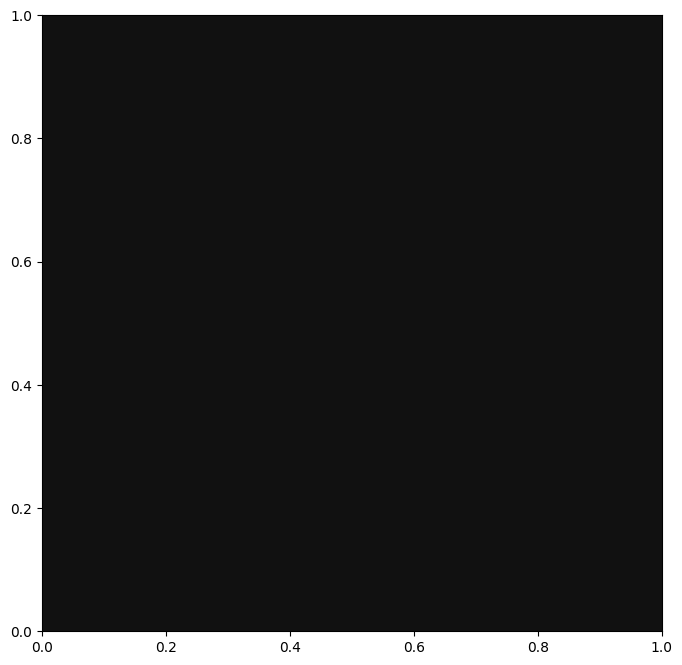

In [ ]:
# Method 1: Display nodes by ID using OSMnx
# Assuming you have a graph 'G' and a list of node IDs 'id_list'
ox.plot_graph(G, node_color='red', node_size=100, 
              show=False, close=False)

# Highlight specific nodes from your ID list
for node_id in nid_l:
    if node_id in G.nodes():
        x, y = G.nodes[node_id]['x'], G.nodes[node_id]['y']
        plt.scatter(x, y, c='blue', s=200, zorder=3)

plt.show()

# Method 2: Create a subgraph with only the nodes from ID list
subgraph = G.subgraph(id)
ox.plot_graph(subgraph, node_color='blue', node_size=10)

# Method 3: Custom node colors based on ID list
node_colors = ['red' if node in nid_l else 'gray' for node in G.nodes()]
ox.plot_graph(G, node_color=node_colors, node_size=50)


In [7]:
# save_graph_csv.py
import osmnx as ox
import pandas as pd
import networkx as nx

# --- PARAMETERS: change the place or bbox as needed ---
place = "Connaught Place, Delhi"   # example; your own area
# G = ox.graph_from_place(place, network_type='drive')   # if you haven't loaded G
G = ox.graph_from_point((28.6314022, 77.2193791), dist=10000, network_type='drive', simplify=True)

# ensure edge travel_time (free-flow) and length exist
G = ox.distance.add_edge_lengths(G)    # adds 'length' in meters
# add a free_flow_speed (m/s) from highway type or maxspeed when available
def infer_speed(u, v, k, data):
    # try to use maxspeed if present
    ms = data.get('maxspeed')
    if ms:
        # maxspeed can be list or string like '50 mph' or '50'
        if isinstance(ms, (list, tuple)):
            ms = ms[0]
        try:
            # take numeric part
            speed_kmh = float(''.join(ch for ch in str(ms) if (ch.isdigit() or ch=='.')))
        except:
            speed_kmh = 30.0
    else:
        # fallback by highway type
        hwy = data.get('highway')
        if hwy:
            if isinstance(hwy, list):
                hwy = hwy[0]
            # crude defaults (km/h)
            if hwy in ['motorway', 'motorway_link']:
                speed_kmh = 100.0
            elif hwy in ['trunk', 'trunk_link']:
                speed_kmh = 80.0
            elif hwy in ['primary', 'primary_link']:
                speed_kmh = 60.0
            elif hwy in ['secondary', 'secondary_link']:
                speed_kmh = 50.0
            elif hwy in ['tertiary', 'tertiary_link']:
                speed_kmh = 40.0
            else:
                speed_kmh = 30.0
        else:
            speed_kmh = 30.0
    # convert to m/s
    return speed_kmh * 1000.0 / 3600.0

# create edges dataframe
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
# ensure unique edge id
edges = edges.reset_index()
edges['edge_id'] = edges.index.astype(int)

# add inferred free_flow_speed (m/s) and free_flow_travel_time (sec)
edges['free_flow_speed_mps'] = edges.apply(lambda row: infer_speed(row['u'], row['v'], row['key'], dict(row)), axis=1)
edges['length_m'] = edges['length'].astype(float)
edges['free_flow_tt_s'] = edges['length_m'] / edges['free_flow_speed_mps']

# nodes
nodes = ox.graph_to_gdfs(G, nodes=True, edges=False)
nodes = nodes.reset_index()

# write CSVs
edges[['edge_id','u','v','key','length_m','free_flow_speed_mps','free_flow_tt_s']].to_csv('edges.csv', index=False)
nodes[['osmid','x','y']].to_csv('nodes.csv', index=False)

print("Wrote edges.csv (N={} rows) and nodes.csv (N={} rows)".format(len(edges), len(nodes)))


passed
Wrote edges.csv (N=167783 rows) and nodes.csv (N=62620 rows)


In [10]:
# synth_traffic.py
import pandas as pd
import numpy as np
from math import exp
from tqdm import tqdm
import os

edges = pd.read_csv('edges.csv')

# time config
steps_per_hour = 12   # 5-min steps
hours = 24
T = hours * steps_per_hour

time_index = pd.date_range("2025-10-01 00:00", periods=T, freq=f"{60//steps_per_hour}min")  # pick a date

# simple time-of-day multiplier function (1.0 = free flow, >1 slower)
def tod_multiplier(hour):
    # base multiplier: low at night, peaks in morning (8-10) and evening (17-19)
    if 0 <= hour < 5:
        return 0.9
    if 5 <= hour < 8:
        return 1.2
    if 8 <= hour < 10:
        return 1.6
    if 10 <= hour < 16:
        return 1.1
    if 16 <= hour < 19:
        return 1.7
    if 19 <= hour < 22:
        return 1.2
    return 0.95

# We'll write in chunks to avoid building everything in memory.
# Try to use pyarrow ParquetWriter for efficient append; fallback to CSV.
chunk_size = 10000  # number of rows to accumulate before flushing; tune as needed
np.random.seed(42)

edges['zone'] = edges['u'] % 10

out_parquet = 'edge_timeseries.parquet'
out_csv = 'edge_timeseries.csv'
# remove existing outputs if any
for p in [out_parquet, out_csv]:
    try:
        if os.path.exists(p):
            os.remove(p)
    except Exception:
        pass

# helper to flush a list of dict rows to disk
def flush_rows(rows, first_write=[True]):
    if not rows:
        return
    df = pd.DataFrame(rows)
    # try parquet via pyarrow with append
    try:
        import pyarrow as pa
        import pyarrow.parquet as pq
        table = pa.Table.from_pandas(df)
        if first_write[0]:
            pq.write_table(table, out_parquet)
            first_write[0] = False
        else:
            # append: open in append mode using ParquetWriter
            with pq.ParquetWriter(out_parquet, table.schema, compression='snappy', use_dictionary=True) as writer:
                writer.write_table(table)
    except Exception as e:
        # fallback to CSV append
        header = True if first_write[0] else False
        df.to_csv(out_csv, mode='a', index=False, header=header)
        first_write[0] = False

# generate streaming
buffer = []
total_rows = 0
for idx, edge in tqdm(edges.iterrows(), total=len(edges)):
    base_speed = edge['free_flow_speed_mps']  # m/s
    length = edge['length_m']
    zone = int(edge['zone'])
    edge_bias = np.random.normal(loc=1.0, scale=0.05)
    for t, ts in enumerate(time_index):
        hour = ts.hour + ts.minute / 60.0
        mult = tod_multiplier(ts.hour)
        zone_effect = 1.0 + (zone - 5) * 0.01
        jitter = np.random.normal(0, 0.05)
        speed = max(0.5, base_speed / (mult * zone_effect * edge_bias + jitter))
        travel_time_s = length / speed
        buffer.append({
            'edge_id': int(edge['edge_id']),
            'timestamp': ts.isoformat(),
            'speed_mps': speed,
            'travel_time_s': travel_time_s
        })
        total_rows += 1
        if len(buffer) >= chunk_size:
            flush_rows(buffer)
            buffer = []
# final flush
flush_rows(buffer)
print('Wrote approx', total_rows, 'rows to', out_parquet, 'or', out_csv)

# quick load head (prefer parquet if exists)
try:
    if os.path.exists(out_parquet):
        df_head = pd.read_parquet(out_parquet)
    else:
        df_head = pd.read_csv(out_csv, nrows=5)
    df_head.head()
except Exception:
    print('Unable to read output preview; file may be large or pyarrow missing')


100%|██████████| 167783/167783 [14:28<00:00, 193.27it/s]


Wrote approx 48321504 rows to edge_timeseries.parquet or edge_timeseries.csv


In [13]:
df_head.tail(10)

,edge_id,timestamp,speed_mps,travel_time_s
1494,167782,2025-10-01T23:10:00,8.390930,23.730768
1495,167782,2025-10-01T23:15:00,9.830233,20.256204
1496,167782,2025-10-01T23:20:00,9.605698,20.729696
1497,167782,2025-10-01T23:25:00,8.322604,23.925589
1498,167782,2025-10-01T23:30:00,10.037281,19.838360
1499,167782,2025-10-01T23:35:00,8.937475,22.279581
1500,167782,2025-10-01T23:40:00,9.662503,20.607828
1501,167782,2025-10-01T23:45:00,10.165515,19.588107
1502,167782,2025-10-01T23:50:00,8.516088,23.382003
1503,167782,2025-10-01T23:55:00,8.365415,23.803145
